In [2]:
# Importação das Bibliotecas
from scipy import stats
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_colwidth', 300)
import pickle
pd.options.plotting.backend = "plotly"

import plotly.express as px

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Instalação Plotly Backend.
!pip install -U plotly

In [3]:
# Carregamento da base de dados
df = pd.read_csv('/content/drive/MyDrive/Arquivos Mentoria/base_tratada/TodosImoveis_tratado_v5.csv', sep=';')
df.head(2)

,link,endereco,rua,bairro,regiao,bairro_cidade,regiao_cidade,cidade,estado,area,quartos,suites,banheiros,vagas,elevador,metro_trem,condominio,iptu,valor,tipo,loc,point,tipo_Apartamento,tipo_Casa,cidade_BeloHorizonte,cidade_RioDeJaneiro,cidade_SaoPaulo
0,http://larimoveis.com.br/imovel/cobertura-3-quartos-a-venda-no-nova-floresta-belo-horizonte-mg-74971/,"Rua Capricórnio, Nova Floresta, Belo Horizonte, Minas Gerais, 31140-240",Rua Capricórnio,NOVA FLORESTA,REGIAO NORDESTE,"BAIRRO NOVA FLORESTA, BELO HORIZONTE, MINAS GERAIS, BRASIL","REGIAO NORDESTE, BELO HORIZONTE, MINAS GERAIS, BRASIL",Belo Horizonte,MINAS GERAIS,157,3,1,3,2,0,0,600,2040.0,650000.0,Apartamento,NaN,"(-19.862296478496713, -43.91179480073082, 0.0)",1,0,1,0,0
1,http://larimoveis.com.br/imovel/apartamento-3-quartos-a-venda-no-graca-belo-horizonte-mg-74955/,"Rua Jataí, Graça, Belo Horizonte, Minas Gerais, 31140-190",Rua Jataí,GRACA,REGIAO NORDESTE,"BAIRRO GRACA, BELO HORIZONTE, MINAS GERAIS, BRASIL","REGIAO NORDESTE, BELO HORIZONTE, MINAS GERAIS, BRASIL",Belo Horizonte,MINAS GERAIS,85,3,1,2,2,0,0,300,1920.0,450000.0,Apartamento,NaN,"(-19.862296478496713, -43.91179480073082, 0.0)",1,0,1,0,0


In [4]:
# Verificando o Shape dos dados
df.shape

(5347, 27)

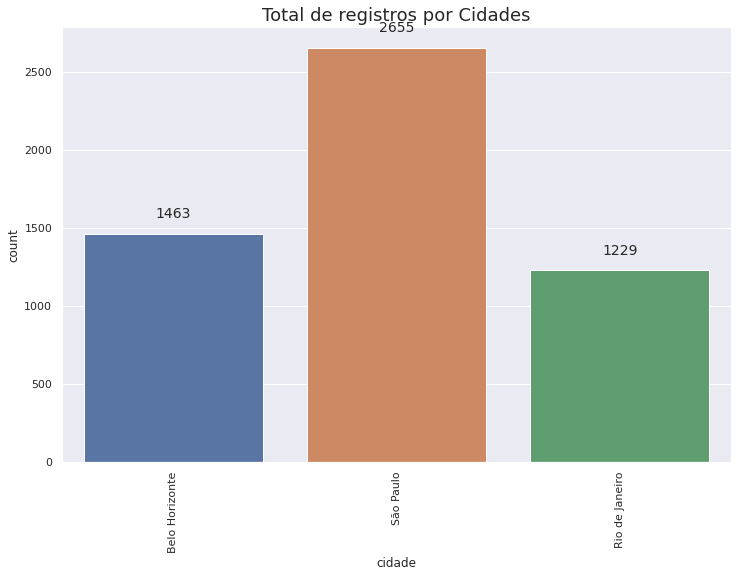

In [11]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=df, x='cidade')

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width() / 2.,
                height + 100,
                height,
                ha="center", fontsize=14) 
plt.xticks(rotation=90);
plt.title("Total de registros por Cidades", fontsize = 18)
plt.show()

In [12]:
# Deletar registros duplicados
df.drop_duplicates(inplace=True)
# Verificar shape
df.shape

(5224, 27)

In [13]:
# Verificar valor Minimo e Máximo do preço de Venda.
df.valor.min(),df.valor.max() 

(890.0, 1880000.0)

In [14]:
# Deletar valor de venda abaixo de 50.000
df.drop(df[df['valor'] <=50000].index, inplace=True)

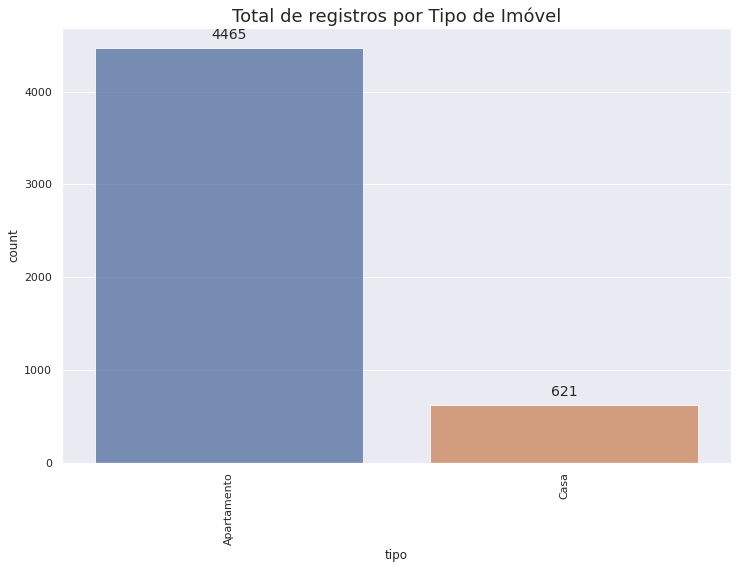

In [15]:
# tipos de Imoveis
plt.figure(figsize=(12,8))
ax = sns.countplot(data=df, x="tipo", alpha=0.8)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+ p.get_width()/2,
          height + 100,
          height,
          ha="center", 
          fontsize=14 
          )

plt.xticks(rotation=90)
plt.title("Total de registros por Tipo de Imóvel", fontsize = 18);

In [16]:
# Bloxplot dos valores dos imóveis.
df.plot(kind='box',x='tipo', y='valor', title = " Valores dos Imóveis")

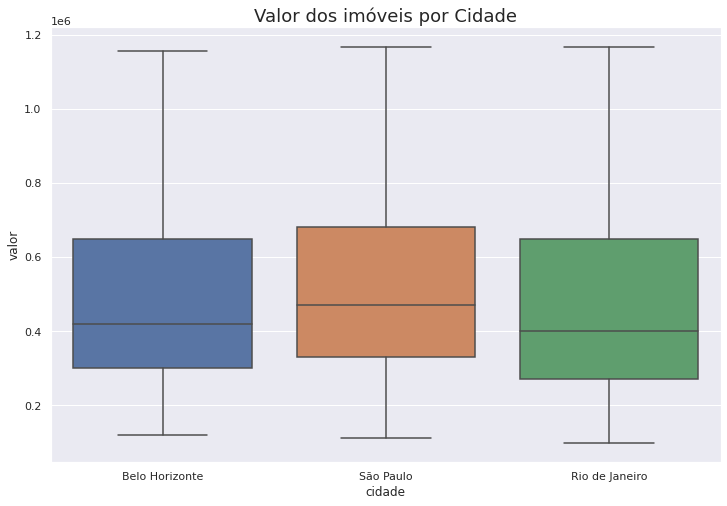

In [25]:
# Valor dos imóveis por Cidade
plt.figure(figsize=(12,8))
sns.boxplot(x='cidade', y='valor', data=df)
plt.title('Valor dos imóveis por Cidade', fontsize = 18);

In [18]:
# Deletar Outliers, valores de imoveis abaixo de 1.170.000
df = df.loc[df.valor < 1170000]
# Shape dos dados
df.shape

(4864, 27)

In [19]:
df.plot(kind='box',x='tipo', y='valor', title = "Valores dos Imóveis (sem Outliers)")

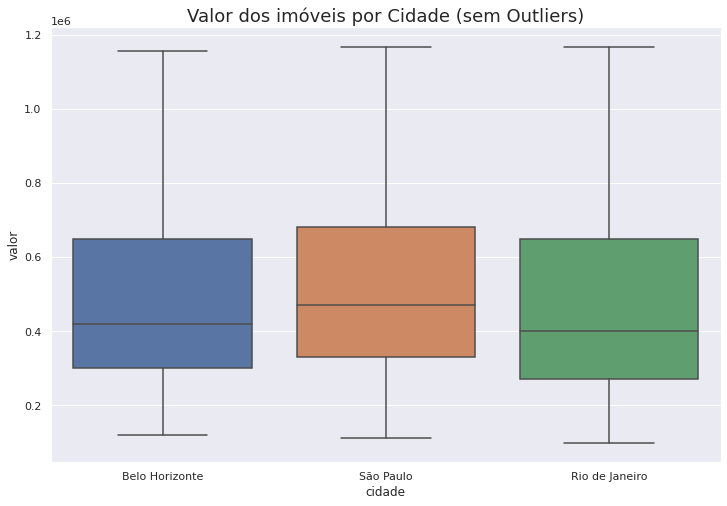

In [27]:
plt.figure(figsize=(12,8))
sns.boxplot(x='cidade', y='valor', data=df)
plt.title('Valor dos imóveis por Cidade (sem Outliers)', fontsize = 18);

In [28]:
# Criação do DataFrame para treinar o Modelo
data = df.iloc[:,[9,10,11,12,13,14,15,16,17,22,23,24,25,26,18]]
data.head()

,area,quartos,suites,banheiros,vagas,elevador,metro_trem,condominio,iptu,tipo_Apartamento,tipo_Casa,cidade_BeloHorizonte,cidade_RioDeJaneiro,cidade_SaoPaulo,valor
0,157,3,1,3,2,0,0,600,2040.0,1,0,1,0,0,650000.0
1,85,3,1,2,2,0,0,300,1920.0,1,0,1,0,0,450000.0
2,86,3,0,1,2,0,0,310,1392.0,1,0,1,0,0,350000.0
3,73,3,1,2,2,0,0,480,2220.0,1,0,1,0,0,710000.0
4,65,2,1,2,2,0,0,480,2220.0,1,0,1,0,0,620000.0


In [29]:
# Estatistica sobre os dados
data.describe()

,area,quartos,suites,banheiros,vagas,elevador,metro_trem,condominio,iptu,tipo_Apartamento,tipo_Casa,cidade_BeloHorizonte,cidade_RioDeJaneiro,cidade_SaoPaulo,valor
count,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4.864000e+03
mean,79.284334,2.250411,0.511102,1.699424,1.103002,0.318257,0.379729,492.202097,1568.871277,0.857319,0.118627,0.283717,0.233758,0.482525,4.998418e+05
std,39.291567,0.770497,0.577422,0.786028,0.760071,0.465848,0.485369,371.233665,1147.494053,0.349783,0.323382,0.450848,0.423264,0.499746,2.417397e+05
min,10.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,52.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,250.000000,750.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.067500e+05
50%,70.000000,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,448.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.400000e+05
75%,96.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,700.000000,2202.000000,1.000000,0.000000,1.000000,0.000000,1.000000,6.600000e+05
max,256.000000,4.000000,2.000000,5.000000,3.000000,1.000000,1.000000,1860.000000,6072.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.166000e+06


In [30]:
# Correlação das Variáveis
data.corr()

,area,quartos,suites,banheiros,vagas,elevador,metro_trem,condominio,iptu,tipo_Apartamento,tipo_Casa,cidade_BeloHorizonte,cidade_RioDeJaneiro,cidade_SaoPaulo,valor
area,1.000000,0.665615,0.406434,0.623474,0.502364,-0.073554,-0.107041,0.034190,0.235238,-0.359868,0.445863,0.109717,-0.043490,-0.062147,0.540991
quartos,0.665615,1.000000,0.395403,0.575209,0.484402,-0.047343,-0.216375,0.089317,0.134935,-0.121481,0.182813,0.242961,-0.080531,-0.150982,0.370487
suites,0.406434,0.395403,1.000000,0.671553,0.482100,0.067896,-0.123269,0.144166,0.184719,-0.086842,0.117938,0.190903,-0.097703,-0.089473,0.429153
banheiros,0.623474,0.575209,0.671553,1.000000,0.515461,0.010834,-0.124420,0.129407,0.212480,-0.230810,0.267315,0.145528,-0.066905,-0.074623,0.497115
vagas,0.502364,0.484402,0.482100,0.515461,1.000000,-0.003163,-0.281067,0.059416,0.218730,-0.183712,0.219668,0.277153,-0.264058,-0.026389,0.408834
elevador,-0.073554,-0.047343,0.067896,0.010834,-0.003163,1.000000,0.147495,0.277803,-0.037325,0.272424,-0.243837,-0.128451,0.055422,0.068942,0.114091
metro_trem,-0.107041,-0.216375,-0.123269,-0.124420,-0.281067,0.147495,1.000000,0.246997,-0.004874,0.125400,-0.077432,-0.459542,0.253489,0.199883,0.107067
condominio,0.034190,0.089317,0.144166,0.129407,0.059416,0.277803,0.246997,1.000000,0.131056,0.489480,-0.430799,-0.223287,0.152607,0.072188,0.404883
iptu,0.235238,0.134935,0.184719,0.212480,0.218730,-0.037325,-0.004874,0.131056,1.000000,-0.145851,0.092854,0.028038,-0.121261,0.077408,0.486480
tipo_Apartamento,-0.359868,-0.121481,-0.086842,-0.230810,-0.183712,0.272424,0.125400,0.489480,-0.145851,1.000000,-0.899289,0.078107,0.082265,-0.140140,-0.115908


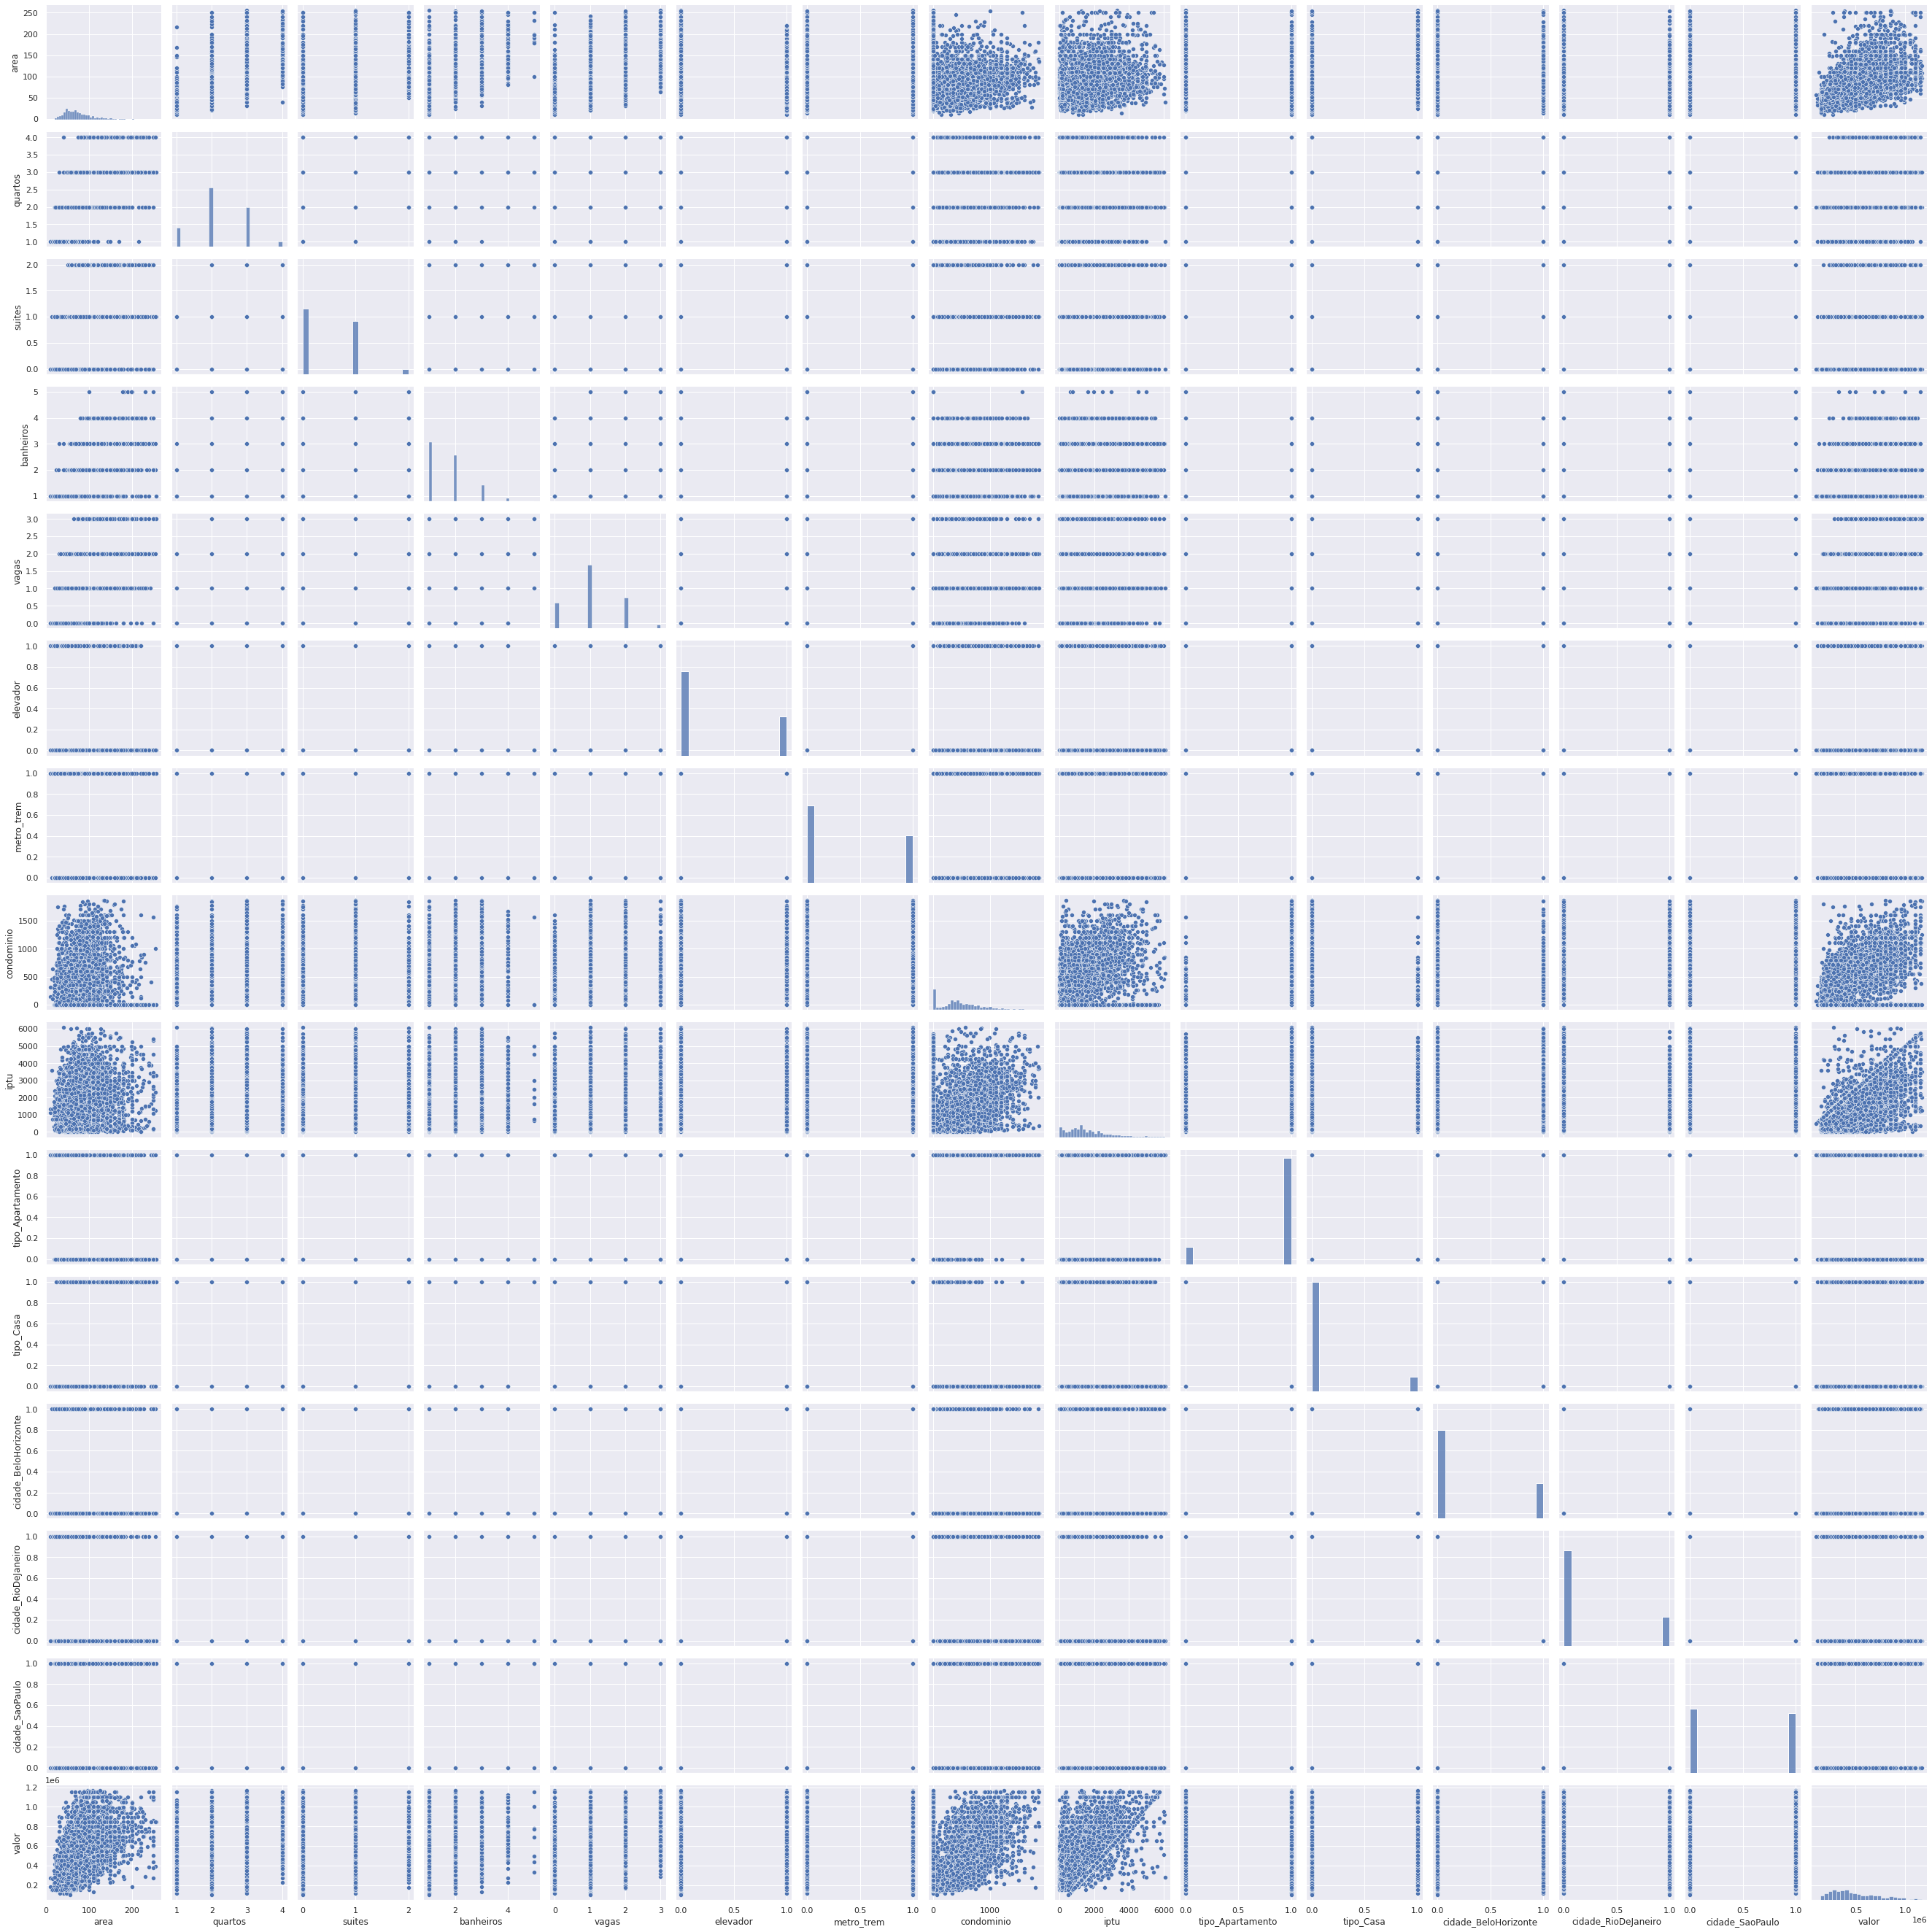

In [31]:
# Análise PairPlot
sns.pairplot(data);

In [32]:
# Verificar valores nulos e Variáveis zeradas
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count().sort_values(ascending=False))
zero = (data.iloc[:,:]==0).sum().sort_values(ascending=False)
percentZero = (data.iloc[:,:]==0).sum() / (data.iloc[:,:]==0).count().sort_values(ascending=False)
missing = pd.concat([total, percent,zero,percentZero], keys=['Total_Null','Percent_Null','Zerado','Percent_Zero'],axis=1)
missing.head(30)

,Total_Null,Percent_Null,Zerado,Percent_Zero
valor,0,0.0,0,0.000000
cidade_SaoPaulo,0,0.0,2517,0.517475
cidade_RioDeJaneiro,0,0.0,3727,0.766242
cidade_BeloHorizonte,0,0.0,3484,0.716283
tipo_Casa,0,0.0,4287,0.881373
tipo_Apartamento,0,0.0,694,0.142681
iptu,0,0.0,0,0.000000
condominio,0,0.0,781,0.160567
metro_trem,0,0.0,3017,0.620271
elevador,0,0.0,3316,0.681743


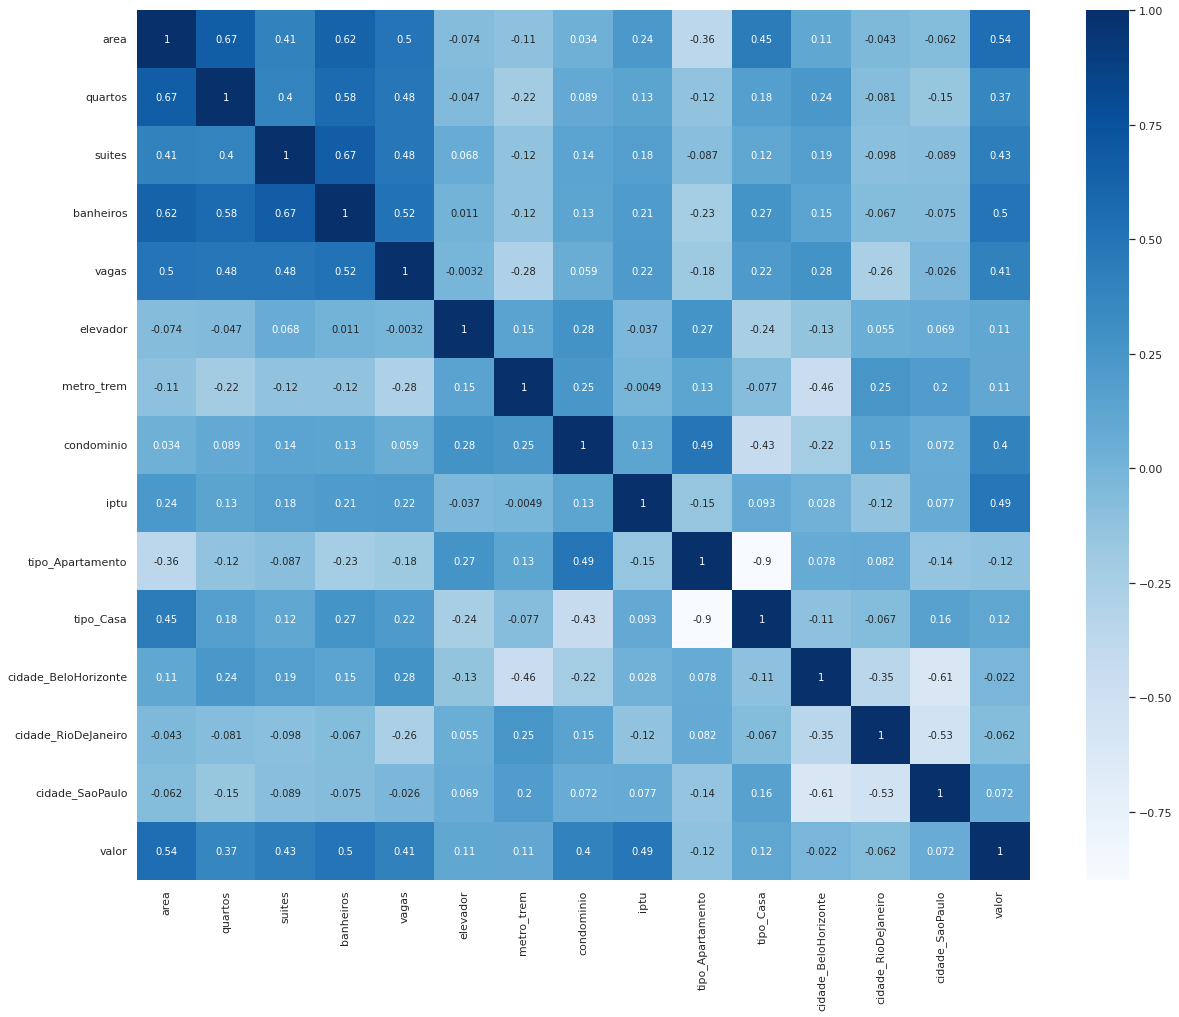

In [ ]:
# Verificar correlação Grafica das variáveis com Seaborn.
plt.figure(figsize=(20,16))
sns.heatmap(data.corr(), annot=True, cmap='Blues');

## Separação das variáveis e Target

In [33]:
# divisão dos atributos e classes
x = data.drop('valor',1).values
y = data.valor.values

# Escalonamento

In [34]:
# MinMaxScaler
MinMax = MinMaxScaler()
x_MinMax = MinMax.fit_transform(x)

In [35]:
x_MinMax

array([[0.59756098, 0.66666667, 0.5       , ..., 1.        , 0.        ,
        0.        ],
       [0.30487805, 0.66666667, 0.5       , ..., 1.        , 0.        ,
        0.        ],
       [0.30894309, 0.66666667, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.28455285, 0.66666667, 0.5       , ..., 0.        , 1.        ,
        0.        ],
       [0.30487805, 0.33333333, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.08130081, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [36]:
# StandardScaler
scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)

# Divisão da base de treino e teste

In [37]:
# Divisão da base de treino e teste.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=41)

In [38]:
# Shape da Divisão das base.
x_train.shape, y_train.shape, x_test.shape,y_test.shape

((4620, 14), (4620,), (244, 14), (244,))

In [39]:
# Criação do Modelo RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=41, criterion='mse',bootstrap= True, max_depth= 110, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=110, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=41, verbose=0, warm_start=False)

### Inverse Transform

In [ ]:
x_test = MinMax.inverse_transform(x_test)
#y_test = MinMax.inverse_transform(y_test)

##Predict

In [40]:
# Realizando o Predict e calculando o Score.
pred_rf = rf.predict(x_test)
rf.score(x_test, y_test)

0.7064281664815906

In [41]:
# Analisando a previsão dos 5 primeiros registros.
pred_rf[:5]

array([657421.57, 351338.  , 183000.  , 395860.  , 446114.18])

In [42]:
# Validando a previsão com os 5 primeiros registros de Teste.
y_test[:5]

array([750000., 340000., 175000., 215000., 518000.])

In [60]:
# Verificar variaveis mais importantes para o Modelo.
corr_data = data.drop('valor',1)
rf_importances = pd.DataFrame(data=rf.feature_importances_ ,index=corr_data.columns, columns=['Score']).sort_values(ascending=True, by='Score')
rf_importances.plot(kind='barh')

In [43]:
# Criação DataFrame para validação da Base, Valor Real x Valor Predito.
validacaoBase = pd.DataFrame(y_test, columns=['ValorReal']) 
validacaoBase['valorPredict'] = pred_rf

In [44]:
# Plot da Validação
fig = validacaoBase.plot(title = " Valor Real x Valor Predito")
fig.show()

In [47]:
# Visualização com ScatterPlot.
fig = px.scatter(validacaoBase, trendline="lowess", title = " Valor Real x Valor Predito")
fig.update_traces(marker_size=15, )
fig.show();

In [48]:
# DataFrame com a difença entre Valor Real e Valor Predito.
validacaoBase['Diferença'] = validacaoBase['ValorReal'] - validacaoBase['valorPredict']
validacaoBase

,ValorReal,valorPredict,Diferença
0,750000.0,657421.570000,92578.430000
1,340000.0,351338.000000,-11338.000000
2,175000.0,183000.000000,-8000.000000
3,215000.0,395860.000000,-180860.000000
4,518000.0,446114.180000,71885.820000
...,...,...,...
239,250000.0,289523.520000,-39523.520000
240,420000.0,420000.000000,0.000000
241,230000.0,246520.575397,-16520.575397
242,450000.0,491099.980000,-41099.980000


In [49]:
# Avaliação do Modelo MAE/MSE
mae = mean_absolute_error(y_test, pred_rf)
mse = mean_squared_error(y_test, pred_rf)
print('Valor Mean Absolute error', '{:,}'.format(round(mae,2)))
print('Valor Mean squared error', '{:,}'.format(round(mse,2)))

Valor Mean Absolute error 86,439.83
Valor Mean squared error 16,493,212,576.5


#cross_val_score

In [50]:
rfs = RandomForestRegressor()
scores = cross_val_score(rfs, x, y, cv=3)

In [51]:
print(scores)

[0.60339502 0.66322683 0.59198133]


In [52]:
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

0.620 accuracy with a standard deviation of 0.031


# Metrica Avaliação

In [53]:
# r2_score
from sklearn.metrics import r2_score

In [54]:
r2_score(y_test, pred_rf, multioutput='variance_weighted')

0.7064281664815906

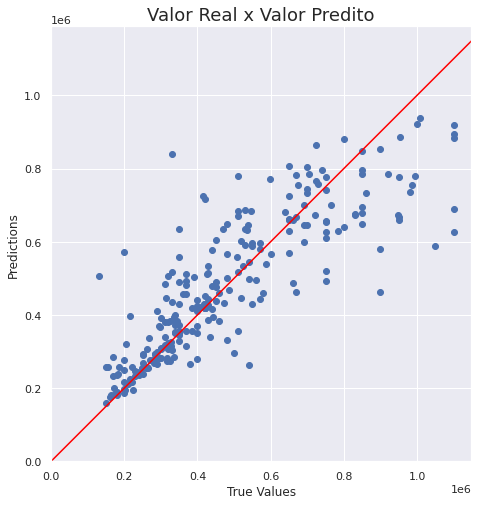

In [56]:
plt.figure(figsize=(12,8))
plt.scatter(y_test, pred_rf)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.title("Valor Real x Valor Predito", fontsize=18)
_ = plt.plot([-10000000, 10000000], [-10000000, 10000000], color='red')

## Função para treinar vários Modelos

In [57]:
def models(x_treino, y_treino,x_teste, y_teste, random_state=41):


  # criando uma lista para armazenar os modelos
  modelos = []
  MAE = []
  NAME = []
  
  # Adicionando os modelos na lista

  modelos.append(('RF', RandomForestRegressor(random_state=random_state)))
  modelos.append(('GBC', GradientBoostingRegressor(random_state=random_state)))
  modelos.append(('LGBMR', lgb.LGBMRegressor(random_state=random_state)))
  modelos.append(('XGBR', xgb.XGBRFRegressor(random_state=random_state)))
  modelos.append(('SVR', SVR()))
  modelos.append(('LR', LinearRegression()))
  modelos.append(('KNNR', KNeighborsRegressor()))

  # Loop pelos Modelos
  for modelo in modelos:
    mod = modelo[1].fit(x_treino, y_treino)
    pred = mod.predict(x_teste)
    score = mod.score(x_teste, y_teste)
    
    print("Modelo",modelo[0], "Score: ", round(score,4))
    mae = mean_absolute_error(y_teste, pred)
    MAE.append(mae)
    NAME.append(modelo[0])
    mse = mean_squared_error(y_teste, pred)
    print('Valor Mean Absolute error',  '{:,}'.format(round(mae,2)))
    print('Valor Mean squared error', '{:,}'.format(round(mse,2)))
    print('\n')

  # DataFrame com os resultados 
  df_result = pd.DataFrame([MAE], columns=NAME).T

  return df_result

In [58]:
# Instanciando o Modelo.
modelos = models(x_train, y_train,x_test, y_test)

Modelo RF Score:  0.687
Valor Mean Absolute error 86,386.4
Valor Mean squared error 17,582,340,614.41


Modelo GBC Score:  0.653
Valor Mean Absolute error 100,449.25
Valor Mean squared error 19,494,274,936.75


Modelo LGBMR Score:  0.6795
Valor Mean Absolute error 90,706.72
Valor Mean squared error 18,008,625,625.06


[18:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Modelo XGBR Score:  0.5511
Valor Mean Absolute error 122,154.58
Valor Mean squared error 25,217,588,011.55


Modelo SVR Score:  -0.0314
Valor Mean Absolute error 188,591.03
Valor Mean squared error 57,944,953,745.54


Modelo LR Score:  0.5768
Valor Mean Absolute error 115,195.65
Valor Mean squared error 23,778,438,054.39


Modelo KNNR Score:  0.4758
Valor Mean Absolute error 116,984.9
Valor Mean squared error 29,449,825,137.65




In [ ]:
# Plot dos Modelos. Avaliação pelo menor Valor MAE.
modelos.plot(kind='bar', title='Valor Mean Absolute Error (MAE) por Modelo')

# Criação Modelo Keras

In [61]:
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(14,)),
    layers.Dense(32, activation='relu'),
  ])

  optimizer = tf.keras.optimizers.RMSprop()

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [62]:
# Instanciando o Modelo
model = build_model()

In [64]:
# EarlyStopping - ReduceLROnPlateau
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rlr = keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.2, patience= 5, verbose=1)

In [65]:
# Imprimindo Sumário do Modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
Total params: 1,536
Trainable params: 1,536
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Realizando fit do Modelo e Armazenando em history.
history = model.fit(
  x_train, y_train,
  epochs=3000, validation_split = 0.15, verbose=1, callbacks= [early_stop, rlr])

Epoch 1/3000
123/123 [==============================] - 1s 3ms/step - loss: 309406629888.0000 - mae: 500516.6250 - mse: 309406629888.0000 - val_loss: 302422818816.0000 - val_mae: 496741.5000 - val_mse: 302422818816.0000
Epoch 2/3000
123/123 [==============================] - 0s 2ms/step - loss: 307159400448.0000 - mae: 498589.2500 - mse: 307159400448.0000 - val_loss: 299490738176.0000 - val_mae: 494155.2812 - val_mse: 299490738176.0000
Epoch 3/3000
123/123 [==============================] - 0s 1ms/step - loss: 303397634048.0000 - mae: 495330.4062 - mse: 303397634048.0000 - val_loss: 295065976832.0000 - val_mae: 490216.2188 - val_mse: 295065976832.0000
Epoch 4/3000
123/123 [==============================] - 0s 1ms/step - loss: 298121723904.0000 - mae: 490718.0625 - mse: 298121723904.0000 - val_loss: 289102528512.0000 - val_mae: 484834.8750 - val_mse: 289102528512.0000
Epoch 5/3000
123/123 [==============================] - 0s 2ms/step - loss: 291353919488.0000 - mae: 484716.5000 - mse: 

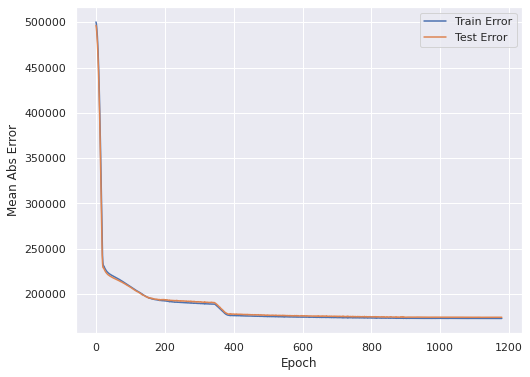

In [67]:
# Verificando valores MAE em Treino e Teste.
plt.figure(figsize=(8,6))
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.history['mae'], label='Train Error')
plt.plot(history.history['val_mae'], label='Test Error')
plt.legend()
plt.show();

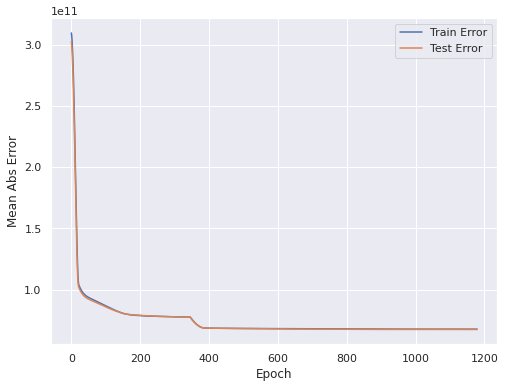

In [68]:
# Verificando valores MSE em Treino e Teste.
plt.figure(figsize=(8,6))
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.history['mse'], label='Train Error')
plt.plot(history.history['val_mse'], label='Test Error')
plt.legend()
plt.show();

In [70]:
# Evaluate
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

8/8 - 0s - loss: 65159532544.0000 - mae: 169264.4375 - mse: 65159532544.0000
Testing set Mean Abs Error: 169264.44


In [72]:
# Predict
test_predictions = model.predict(x_test).flatten()

In [73]:
# Analisando a previsão dos 5 primeiros registros.
test_predictions[:5]

array([681574.06, 683078.8 ,      0.  , 682991.56, 683169.94],
      dtype=float32)

In [74]:
# Validando a previsão com os 5 primeiros registros de Teste.
y_test[:5]

array([750000., 340000., 175000., 215000., 518000.])

###RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 49, 88, 127, 166, 205, 244, 283, 322, 361, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# RandomizedSearchCV
rff = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rff,  param_distributions = random_grid, n_iter = 100,  
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# Realizando o Treinamento
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
# Print dos Melhores Parametros
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

In [ ]:
# Instanciando a Melhor configuração para o Modelo.
best_random = rf_random.best_estimator_

In [ ]:
# Verificando o Score.
best_random.score(x_test,y_test)

0.7015317535791131

In [ ]:
# Realizand a previsão com Modelo
best_pred = best_random.predict(x_test)

In [ ]:
# MAE - MSE
mae = mean_absolute_error(y_test, best_pred)
mse = mean_squared_error(y_test, best_pred)
print('Valor Mean Absolute error', mae)
print("\n")
print('Valor Mean squared error', mse)

Valor Mean Absolute error 87832.24469628352


Valor Mean squared error 16768298840.375015


#### Salvar Melhor modelo treinando com toda a base

In [ ]:
# Treinando o Melhor Modelo com a base Full.
rf = RandomForestRegressor(n_estimators=100, random_state=41, criterion='mse',bootstrap= True, max_depth= 110, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2)
rf.fit(x, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=110, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=41, verbose=0, warm_start=False)

In [ ]:
# Salvar Modelo final.
with open('Modelo_RF_v3.pkl','wb') as file:
  pickle.dump(rf,file)